In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import exchange_calendars as xcals  
from pandas.tseries.offsets import BMonthEnd
import re
from scipy.stats import norm
from scipy.optimize import brentq

In [2]:
options_data=pd.read_csv("C:/Users/14335/Desktop/隐含波动率指数研究/华夏上证50ETF 合并.csv")
futures_data=pd.read_excel("C:/Users/14335/Desktop/510050_日线数据.xlsx")

In [3]:
# 分裂字符为'type'列
options_data['合约类型'] = options_data['合约代码'].str[15:17]

In [4]:
# 将整数转换为字符串，再转换为日期时间对象
options_data['交易日期'] = pd.to_datetime(options_data['交易日期'].astype(str), format='%Y%m%d')
options_data['到期日'] = pd.to_datetime(options_data['到期日'].astype(str), format='%Y%m%d')
# 将日期时间对象格式化为 'YYYY/MM/DD' 格式的字符串
options_data['交易日期'] = options_data['交易日期'].dt.strftime('%Y/%m/%d')
options_data['到期日'] = options_data['到期日'].dt.strftime('%Y/%m/%d')
print(options_data)


                         合约代码           代码        交易日期         到期日 交易市场  \
0       华夏上证50ETF期权1503认购2.20  10000001.SH  2015/03/25  2015/03/25  SSE   
1       华夏上证50ETF期权1503认购2.20  10000001.SH  2015/03/24  2015/03/25  SSE   
2       华夏上证50ETF期权1503认购2.20  10000001.SH  2015/03/23  2015/03/25  SSE   
3       华夏上证50ETF期权1503认购2.20  10000001.SH  2015/03/20  2015/03/25  SSE   
4       华夏上证50ETF期权1503认购2.20  10000001.SH  2015/03/19  2015/03/25  SSE   
...                       ...          ...         ...         ...  ...   
289742  华夏上证50ETF期权2407认沽2.30  10007426.SH  2024/05/31  2024/07/24  SSE   
289743  华夏上证50ETF期权2407认沽2.30  10007426.SH  2024/05/30  2024/07/24  SSE   
289744  华夏上证50ETF期权2407认沽2.30  10007426.SH  2024/05/29  2024/07/24  SSE   
289745  华夏上证50ETF期权2407认沽2.30  10007426.SH  2024/05/28  2024/07/24  SSE   
289746  华夏上证50ETF期权2407认沽2.30  10007426.SH  2024/05/27  2024/07/24  SSE   

          昨结算价    前收盘价     开盘价     最高价     最低价     收盘价     结算价  成交量(手)  \
0       0.4415  0.4415  0

In [5]:
options_data['到期日'] = pd.to_datetime(options_data['到期日'])
options_data['交易日期'] = pd.to_datetime(options_data['交易日期'])

In [6]:
options_data['t']=(options_data['到期日']-options_data['交易日期']).dt.days

In [7]:
futures_data['交易日期'] = pd.to_datetime(futures_data['交易日期'])
merged_df = pd.merge(options_data, futures_data[['交易日期',  '收盘']],how='left', on=['交易日期'])
merged_df = merged_df.rename(columns={'收盘': '标的资产价格'})
merged_df.head(30)


,合约代码,代码,交易日期,到期日,交易市场,昨结算价,前收盘价,开盘价,最高价,最低价,收盘价,结算价,成交量(手),成交金额(万元),持仓量(手),行权价,合约类型,t,标的资产价格
0,华夏上证50ETF期权1503认购2.20,10000001.SH,2015-03-25,2015-03-25,SSE,0.4415,0.4415,0.4380,0.4380,0.3884,0.4007,0.4040,298.0,124.4646,1957.0,2.20,认购,0,2.279
1,华夏上证50ETF期权1503认购2.20,10000001.SH,2015-03-24,2015-03-25,SSE,0.4765,0.4742,0.4861,0.4861,0.4133,0.4415,0.4415,228.0,101.5972,2155.0,2.20,认购,1,2.308
2,华夏上证50ETF期权1503认购2.20,10000001.SH,2015-03-23,2015-03-25,SSE,0.4363,0.4290,0.4450,0.4798,0.4450,0.4742,0.4765,262.0,121.8489,2256.0,2.20,认购,2,2.342
3,华夏上证50ETF期权1503认购2.20,10000001.SH,2015-03-20,2015-03-25,SSE,0.3902,0.3902,0.4053,0.4679,0.3811,0.4290,0.4363,558.0,237.9963,2368.0,2.20,认购,5,2.306
4,华夏上证50ETF期权1503认购2.20,10000001.SH,2015-03-19,2015-03-25,SSE,0.4128,0.4044,0.3983,0.4050,0.3762,0.3902,0.3902,427.0,166.2263,2497.0,2.20,认购,6,2.264
5,华夏上证50ETF期权1503认购2.20,10000001.SH,2015-03-18,2015-03-25,SSE,0.3451,0.3385,0.3467,0.4044,0.3467,0.4044,0.4128,571.0,212.2374,2596.0,2.20,认购,7,2.285
6,华夏上证50ETF期权1503认购2.20,10000001.SH,2015-03-17,2015-03-25,SSE,0.3125,0.3075,0.3264,0.3417,0.3172,0.3385,0.3451,697.0,231.3861,2789.0,2.20,认购,8,2.225
7,华夏上证50ETF期权1503认购2.20,10000001.SH,2015-03-16,2015-03-25,SSE,0.2570,0.2570,0.2685,0.3099,0.2549,0.3075,0.3125,1245.0,355.4893,2899.0,2.20,认购,9,2.196
8,华夏上证50ETF期权1503认购2.20,10000001.SH,2015-03-13,2015-03-25,SSE,0.2525,0.2525,0.2559,0.2949,0.2432,0.2570,0.2570,1300.0,351.2310,3160.0,2.20,认购,12,2.148
9,华夏上证50ETF期权1503认购2.20,10000001.SH,2015-03-12,2015-03-25,SSE,0.1774,0.1774,0.1870,0.2696,0.1870,0.2525,0.2525,2159.0,506.5646,2880.0,2.20,认购,13,2.142


In [9]:

merged_df = merged_df.dropna(subset=['标的资产价格'])


In [10]:
merged_df["moneyness"]=merged_df["行权价"] / merged_df["标的资产价格"].astype(float)
output_file = r"C:/Users/14335/Desktop/option_with_moneyness.xlsx"
merged_df.to_excel(output_file, index=False)

In [18]:
df = pd.read_excel("C:/Users/14335/Desktop/50ETF_options类型.xlsx")
r = 0.02259 #无风险利率此处取十年期国债利率 
def d_one(F0, K, sigma, T, r):
    numerator = np.log(F0 / K) + (r + 0.5*sigma ** 2 ) * T
    denominator = sigma * np.sqrt(T)
    d1 = numerator / denominator
    return d1
def call_option_price(F0, K, r, T, sigma):
    d1 = d_one(F0, K, sigma, T, r)
    d2 = d1 - sigma * np.sqrt(T)
    price = F0 * norm.cdf(d1) - K * np.exp(-r * T) *norm.cdf(d2)
    return price

def put_option_price(F0, K, r, T, sigma):
    d1 = d_one(F0, K, sigma, T, r)
    d2 = d1 + sigma * np.sqrt(T)
    price = K * np.exp(-r * T) * norm.cdf(-d2) - F0 *norm.cdf(-d1)
    return price

def implied_volatility(row):
    right = row['合约类型']
    F0 = row['标的资产价格']
    K = row['行权价']
    T = row['t'] /252
    price = row['收盘价']

    def option_price_function(sigma):
        if right == '认购':
            d1 = d_one(F0, K, sigma, T, r)
            d2 = d1 - sigma * np.sqrt(T)
            return F0 * norm.cdf(d1) - K * np.exp(-r *T) * norm.cdf(d2) - price
        elif right == '认沽':
            d1 = d_one(F0, K, sigma, T, r)
            d2 = d1 - sigma * np.sqrt(T)
            return K * np.exp(-r * T) * norm.cdf(-d2)- F0 * norm.cdf(-d1) - price
        else:
            return np.nan

    
    result = brentq(option_price_function, -0.00001,4,maxiter=1000)
    return result

df['Implied_volatility'] =df.apply(implied_volatility, axis=1)
df.to_excel(r"C:/Users/14335/Desktop/50ETF_Implied_volatility.xlsx", index=False)
print(df[ 'Implied_volatility'])

0         1.163588
1         1.086701
2         1.065544
3         0.973727
4         0.955866
            ...   
207444    0.119778
207445    0.122551
207446    0.119380
207447    0.117012
207448    0.118719
Name: Implied_volatility, Length: 207449, dtype: float64


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
# 读取 Excel 文件
file_path = "C:/Users/14335/Desktop/50ETF_Implied_volatility.xlsx"
df = pd.read_excel(file_path)
# 将日期转换为 datetime 类型
df['Date'] = pd.to_datetime(df['交易日期'])
# 确保数据按照日期排序
df = df.sort_values(by='Date')
# 确保这个路径是在您的环境中可写的
save_path = "C:/Users/14335/Desktop"


In [1]:
def plot_daily_avg_iv(df):
    atm_df =df[(df['期权类型']== 'ATM')]
    daily_avg_iv =atm_df.groupby('Date')['Implied_volatility'].mean().reset_index()
    plt.figure(figsize=(15, 8))
    plt.plot(daily_avg_iv['Date'],daily_avg_iv['Implied_volatility'], label='Daily Avg.Implied Volatility', linestyle='-', linewidth=1,color='b', marker=None)
    plt.title('Implied Volatility Level')
    plt.xlabel('Date')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path + 'Implied VolatilityLevel.png')
    plt.show()

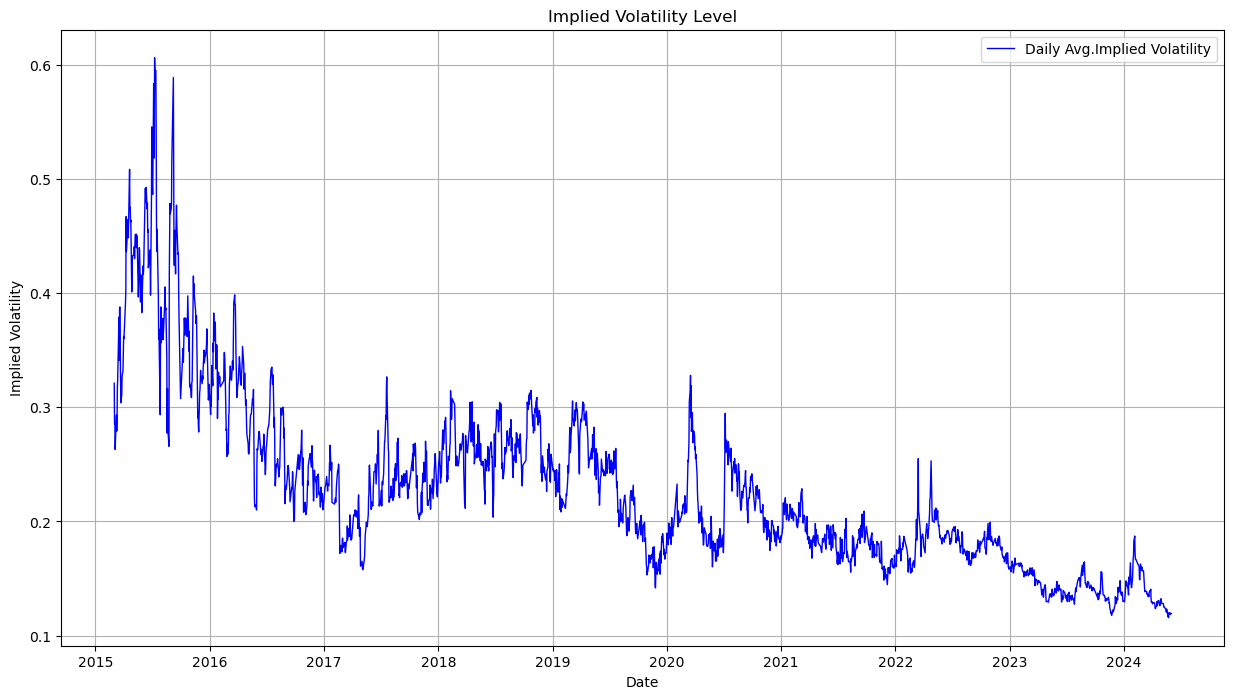

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
# Run the plotting functions
plot_daily_avg_iv(df)

In [14]:
df=pd.read_excel("C:/Users/14335/Desktop/隐含波动率指数研究/option50ETF.xlsx")
df['合约名称']=df['合约代码'].str[0:15]
df.to_excel("C:/Users/14335/Desktop/option数据处理.xlsx")

In [15]:
import pandas as pd


df=pd.read_excel("C:/Users/14335/Desktop/option数据处理.xlsx")
# 计算标的资产价格和执行价格之间的差异，并添加为新的列
df['diff'] =abs (df['标的资产价格'] - df['行权价'])

# 按照合约代码和交易日期进行分组，然后过滤那些组内只有一条记录的数据
df = df.groupby(['合约名称', '交易日期']).filter(lambda x: len(x) > 1)

# 找到每个分组内 diff 最小的行，作为平值期权的执行价格
atm_strike_prices = df.loc[df.groupby(['合约名称', '交易日期'])['diff'].idxmin(), ['合约名称', '交易日期', '行权价']]

# 确定期权状态的函数
def determine_option_status(row, atm_strike_prices):
    atm_strike_price = atm_strike_prices[(atm_strike_prices['合约名称'] == row['合约名称']) & 
                                         (atm_strike_prices['交易日期'] == row['交易日期'])]['行权价'].values[0]
    if row['行权价'] == atm_strike_price:
        return 'ATM'
    elif (row['合约类型'] == '认购' and row['行权价'] < atm_strike_price) or (row['合约类型'] == '认沽' and row['行权价'] > atm_strike_price):
        return 'ITM'
    else:
        return 'OTM'

# 应用函数，确定每个期权的状态
df['期权类型'] = df.apply(determine_option_status, axis=1, atm_strike_prices=atm_strike_prices)

df.to_excel("C:/Users/14335/Desktop/50ETF_options类型.xlsx")
print(f"Results have saved")


Results have saved


In [8]:
option_df=pd.read_excel("C:/Users/14335/Desktop/隐含波动率指数研究/option_with_moneyness.xlsx")
option_df =option_df[option_df['t']>14]
option_df.to_excel("C:/Users/14335/Desktop/隐含波动率指数研究/option50ETF.xlsx")

In [24]:
atm_df =df[(df['期权类型']== 'ATM')]
daily_avg_iv =atm_df.groupby('Date')['Implied_volatility'].mean().reset_index()
daily_avg_iv.to_excel("C:/Users/14335/Desktop/隐含波动率指数研究/impolied_volatility_50etf.xlsx")